In [1]:
#Libraries
import random as rd
import math
import numpy as np
import operator
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
Logs = True

In [2]:
#Function tools
def feature_extractor(image, box_size = 6, stride = 6, ignore_borders = 2):
    """Receives a numpy matrix as image, returns mean and standard deviation for every squared box in a list"""
    features = []
    image = image[ ignore_borders : -ignore_borders , ignore_borders : -ignore_borders]
    horizontal_jumps = int((image.shape[0] - box_size) / stride)
    vertical_jumps = int((image.shape[1] - box_size) / stride)
    for i in range(horizontal_jumps):
        for j in range(vertical_jumps):
            vertical_start = j * stride
            horizontal_start = i * stride
            box = image[ vertical_start : vertical_start + box_size , horizontal_start : horizontal_start + box_size]
            features.append(np.mean(box))
            features.append(np.std(box))
    return np.array(features)
    
def safe_divide(a, b):
    """This function provides a 'safe' division for two numbers. If the denominator b
    is 0, the function will return 0"""
    if b == 0 :
        return 0
    else:
        return a/b
    
def signed_if(a, b, c):
    """This function works as an if which interprets the first argument 'a' as False if negative
    and returns 'b', else 'c'"""
    if a < 0 :
        return b
    else:
        return c

In [3]:
class SymbollicTreeFunction:
    def __init__(
            self,
            features,
            evaluate_fitness_f,
            max_initial_depth = 3):
        """
        Arguments:
            features: number of features the tree will expect
            dimensions: sample dimensions or features amount
            max_initial_depth: restricts depth of generated functions in their tree representation.
        """
        self.features = features
        self.evaluate_fitness_f = evaluate_fitness_f
        self.max_initial_depth = max_initial_depth 
    
    def generate_terminal(self):
        """features is the amount of features available for each sample, as an int"""
        #global variable: dimensions
        is_constant = False
        value = rd.randint(0, self.features)
        if value == self.features:
            is_constant = True
            value = np.random.uniform()
        return value
        
    def _generate_individual(self, parent=None, depth=0): #OK
        """Generate an individual within the initial population."""
        if depth == self.max_initial_depth:
            terminal = self.generate_terminal()
            return Node(terminal, parent, None, None)
        else:
            node = Node(self._generate_operator(), parent, None, None)
            node.left_child = self._generate_individual(parent=node, depth=depth+1)
            node.right_child = self._generate_individual(parent=node, depth=depth+1)
            return node
    
    def _generate_operator(self): #OK. To do: add if
        """Generate an operator. Operators can be '+','-','*' or '/'. This function is used for generating
        individuals in the initial population (_generate_individual) and for generating new trees during the mutation process
        (_mutate_tree)."""
        return rd.choice([operator.add, operator.sub, operator.mul, safe_divide])
    
    def evaluate(self, population):
        """This function evaluates the fitness of one individual."""
        evaluations = self.evaluate_fitness_f(population)
        return evaluations
    
    def _crossover(self, probabilities, amount):
        """Create a crossover randomly chosen individuals. Probabilities is a tuple of lists of the functions of the individuals and
        their corresponding scaled fitness score. The variable 'amount' defines how many crossovers are created."""
        new_individuals = []
        first_parents = self._sample_population(probabilities, amount)
        second_parents = self._sample_population(probabilities, amount)
        for first_parent, second_parent in zip(first_parents, second_parents):
            new_individuals.append(self._crossover_trees(first_parent, second_parent))
        return new_individuals
    
    def _mutate(self, probabilities, amount):
        """Mutate randomly chosen individuals. Probabilities is a tuple of lists of the functions of the individuals and
        their corresponding scaled fitness score. The variable 'amount' defines how many crossovers are created."""
        new_individuals = []
        parents = self._sample_population(probabilities, amount)
        for parent in parents:
            new_individuals.append(self._mutate_tree(parent))
        return new_individuals
    
    def _sample_population(self, probabilities, amount):
        """Choose individuals randomly. Individuals with a lower fitness score (a lower error) are more likely to be 
        chosen. Probabilities is a tuple of lists of the functions of the individuals and their corresponding scaled 
        fitness score. The variable 'amount' defines how many crossovers are created."""
        population, weights = zip(*probabilities)
        return rd.choices(population=population,weights=weights,k=amount)
    
    def _collect_nodes(self, root_node):
        """Function to get a list of the nodes in one tree. Used in _mutate_tree and _crossover_trees."""
        nodes = [root_node]
        i = 0
        while i < len(nodes):
            if not nodes[i].is_terminal():
                nodes.append(nodes[i].left_child)
                nodes.append(nodes[i].right_child)
            i += 1
        return nodes
    
    def _mutate_tree(self, parent):
        """This function mutates one parent. A mutation point is chosen randomly among all nodes. The tree is mutated
        at that point by changing the node at that mutation point."""
        # TO-DO #5 make mutation more advanced. Right now it is just changing a terminal to another terminal and
        # an operator to another operator
        new_tree = parent.copy()
        nodes = self._collect_nodes(new_tree)
        mutation_point = rd.choice(nodes)
        if mutation_point.is_terminal():
            mutation_point.content = self.generate_terminal()
        else:
            mutation_point.content = self._generate_operator()
        return new_tree
    
    def mutate(self, parent):
        """This function mutates one parent. A mutation point is chosen randomly among all nodes. The tree is mutated
        at that point by changing the node at that mutation point."""
        # TO-DO #5 make mutation more advanced. Right now it is just changing a terminal to another terminal and
        # an operator to another operator
        new_tree = parent.copy()
        nodes = self._collect_nodes(new_tree)
        mutation_point = rd.choice(nodes)
        if mutation_point.is_terminal():
            mutation_point.content = self.generate_terminal()
        else:
            mutation_point.content = self._generate_operator()
        return new_tree
    
    def _crossover_trees(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
        
    def crossover(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
    
class Node:
    def __init__(self, content, parent, left_child, right_child):
        self.content = content
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        
    def __str__(self):
        if self.is_terminal():
            return str(self.content)
        else:
            return "(" + self.content.__name__ + " " + str(self.left_child) + " " + str(self.right_child) + ")"
    
    def is_terminal(self):
        return self.left_child is None and self.right_child is None
    
    def is_root(self):
        return self.parent is None
    
    def copy(self, parent=None):
        the_copy = Node(self.content, parent, None, None)
        if not self.is_terminal():
            the_copy.left_child = self.left_child.copy(parent=the_copy)
            the_copy.right_child = self.right_child.copy(parent=the_copy)
        return the_copy

In [4]:
class IndividualClass:
    def __init__(self, fenotype, evaluation = None, selection_chances = None):
        self.fenotype = fenotype
        self.evaluation = evaluation
        self.selection_chance = selection_chances
    
    def __str__(self):
        return str(self.__dict__)

class GeneticAlgorithm:
    def __init__(
            self,
            population_size,
            generations,
            sampling_method="tournament",
            elite_ratio=0,
            mutation_ratio=0.02,
            sample_ratio=0,
            tournament_size=2):
        """
        Arguments:
        population_size
        generations
        sampling_method: can be tournament / weighted_random / random
        elite_ratio is the ratio of best population which will be kept as it is, and are also the parents for the next generation
        mutation_ratio is the ratio of the next generation non-elite population to be filled with mutation-generated individuals
        sample_ratio is the ratio of the next generation's non-elite population to be filled with sampled individuals
        tournament_size only used if sampling method is tournament. Best out from randomly selected individuals will be selected for sampling
        """  
        self.generations = generations
        self.population_size = population_size
        self.sampling_method = sampling_method
        self.elite_ratio = elite_ratio
        self.mutation_ratio = mutation_ratio
        self.sample_ratio = sample_ratio
        self.tournament_size = tournament_size
        
        
    def __str__(self):
        return str(self.__dict__)
    
    def _weighted_random_sample(self, parent_population, amounts):
        "returns weighted randomly selected individuals. if amount is a list, returns a list of lists"""
        total_proportion = sum([1/individual.evaluation for individual in parent_population])
        probabilities = []
        sample = []
        for individual in parent_population:
            probability = 1/(individual.evaluation * total_proportion)
            individual.selection_chance = probability
            probabilities.append(probability)
        for amount in amounts:
            sample.append(rd.choices(parent_population, weights = probabilities, k = amount))
        return sample
    
    def _tournament_selection(self, parent_population, amounts):
        selection = []
        for amount in amounts:
            for i in range(amount):
                competitors = rd.choices(parent_population, amount = self.tournament_size)
                
        return selection
    
    def fit(self, Model):
        """
        Tries to minimize evaluation function in the model, returns the best individual"
        to do: include -- crossover_method can be "pivot" or "annular"
        """
        self.Model = Model
        population = [IndividualClass(Model._generate_individual()) for _ in range(self.population_size)]
        
        #amounts of each population type and procedence
        archive_population_size = math.ceil(self.population_size * self.elite_ratio)
        
        offspring_population_size = self.population_size - archive_population_size
        samples = math.ceil(offspring_population_size * self.sample_ratio)
        mutations = math.ceil(offspring_population_size * self.mutation_ratio)
        crossovers = offspring_population_size - samples - mutations
        if Logs: 
            print("population_size", self.population_size)
            print("archive_population_size", archive_population_size)
            print("offspring_population_size", offspring_population_size)
            print("samples", samples)
            print("mutations", mutations)
            print("crossovers", crossovers)
            
        for generation in range(self.generations):
            if Logs: print("generation:", generation)
            
            #evaluation of every individual
            individuals_fitness = Model.evaluate([individual.fenotype for individual in population])
            for i,individual in enumerate(population):
                individual.evaluation = individuals_fitness[i]
                
            #Parents selection
            population = sorted(population, key = lambda x: x.evaluation)
            archive_population = population[:archive_population_size]
            parent_population = archive_population       
            if self.sampling_method == "weighted_random":
                individual_selections = self._weighted_random_sample(parent_population, [crossovers, crossovers, samples, mutations])
            elif self.sampling_method == "tournament":
                individual_selections = self._tournament_selection(parent_population, [crossovers, crossovers, samples, mutations])
            first_parents = individual_selections[0]
            second_parents = individual_selections[1]
            
            #new population
            new_population = archive_population
            new_population.extend(individual_selections[2])
            new_population.extend([IndividualClass(Model.mutate(individual.fenotype)) for individual in individual_selections[3]])
            new_population.extend([IndividualClass(Model.crossover(first_parents[i].fenotype, second_parents[i].fenotype)) for i in range(crossovers)])
            population = [i for i in new_population]
        
        
        return darwin_champion.fenotype, darwin_champion.evaluation    

In [38]:
class ImageClassificationWithMOGP:
    def __init__(self, x_train, x_test, y_train, y_test, goal_classes = None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        if goal_classes is None:
            self.goal_classes = []
        else:
            self.goal_classes = goal_classes
        self.objectives_size = len(self.goal_classes)
        self.dimensions = len(x_train[0])
        self.test_mode(False)
        
    def test_mode(self, activated = True):
        if activated:
            self.x = self.x_test
            self.y = self.y_test
        else:
            self.x = self.x_train
            self.y = self.y_train
        self.data_size = len(self.x)
    
    def evaluate_tree_class_accuracy(self, node, goal_class = 0):
        y_evaluation = [1 if self.evaluate_tree_image(i, node) < 0 else 0 for i in range(self.data_size)]
        corrects = sum([1 if y_evaluation[i] == self.y[i] and self.y[i] == goal_class else 0 for i in range(self.data_size)])
        total = sum([1 if self.y[i] == goal_class else 0 for i in range(self.data_size)])
        accuracy = corrects / total

        return accuracy   

    def crowding_distance(self, objective_values):
        objective_values = np.array(objective_values)
        crowd = len(objective_values[0])
        indexes = [i for i in range(crowd)]
        for objective_index in range(self.objectives_size):
            temp_zip = np.array(zip(objective_values[objective_index], indexes))
            print(temp_zip[0])
            sorted_temp_zip = sorted(temp_zip, key = lambda x: x[1])
            print(objective_index, sorted_temp_zip[:,1])
             
        return crowding_distances

    def evaluate_fitness_SPEA2(self, nodes):
        #initial calculations
        population_size = len(nodes)

        #variable initialisation
        evaluations = []
        objective_values = []
        strenghts = []

        #accuracies calculations
        for objective_index in range(self.objectives_size):
            values = []
            for node in nodes:
                values.append(self.evaluate_tree_class_accuracy(node, self.goal_classes[objective_index])) #needs adaptation
            objective_values.append(values)
            
        #strenghts calculation
        for evaluated_individual_index in range(population_size):
            dominated_solutions = 0
            for comparison_individual_index in range(population_size):
                dominated = True
                for objective_index in range(self.objectives_size):
                    if objective_values[objective_index][evaluated_individual_index] < objective_values[objective_index][comparison_individual_index]:
                        dominated = False
                        break
                if dominated:
                    dominated_solutions += 1   
            strenghts.append(dominated_solutions)
        #if Logs: colored_plot(positive_accuracies, negative_accuracies, strenghts, title = "strenghts", colormap = "cool")

        #fitness   
        for evaluated_individual_index in range(population_size):
            total_strenghts = 0
            for comparison_individual_index in range(population_size):
                dominates_me = True
                for objective_index in range(self.objectives_size):
                    if objective_values[objective_index][evaluated_individual_index] >= objective_values[objective_index][comparison_individual_index]:
                        dominates_me = False
                        break
                if dominates_me:
                    total_strenghts += strenghts[comparison_individual_index]   
            evaluations.append(total_strenghts + 1)
        
        #self.crowding_distance(objective_values)
        #print("Evaluations:", len(evaluations))
        if Logs: 
            self.colored_plot(objective_values[0], objective_values[1], evaluations, title = "SPEA2", colormap = "cool") #hardcoded for 2 objectives
        return evaluations


    def evaluate_tree_image(self, sample_index, node): #node is the root node of the tree
        """Evaluates the value of one node in a tree. It calls itself to move through the whole tree."""
        if not node.is_terminal():
            return node.content(
                self.evaluate_tree_image(sample_index, node.left_child),
                self.evaluate_tree_image(sample_index, node.right_child))
        elif isinstance(node.content, int):
            return self.x[sample_index][node.content]
        else:
            return node.content
        
    def colored_plot(self, x, y, values, title = "", colormap = "cool"):
        """points are x, y pairs, values are used for graduated coloring"""
        max_value = max(values)
        min_value = min(values)
        colors = [1 - (value - min_value) / (max_value - min_value) for value in values]
        plt.scatter(x, y, c = colors, cmap = colormap, alpha = 0.6)
        plt.title(title)
        plt.grid()
        plt.show()


In [40]:
#Data extraction
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array([image.reshape((28,28)) for image in X])
y = np.array(y)

In [41]:
#Data pre-processing
X_features = [feature_extractor(x) for x in X]
max_feature = max([max(x) for x in X_features])
X_normalised_features = [x / max_feature for x in X_features]
y_temp = [1 if label == "2" else 0 for label in y] #hardcoded to class 2

x_train, x_test, y_train, y_test = train_test_split(X_normalised_features, y_temp, test_size = 0.8)
print(len(y_test))

56000


In [42]:
#Elaboration
Problem = ImageClassificationWithMOGP(x_train, x_test, y_train, y_test, [1,0])

Model = SymbollicTreeFunction(
    features = Problem.dimensions,
    evaluate_fitness_f = Problem.evaluate_fitness_SPEA2,
    max_initial_depth = 3,
    )

MOGP = GeneticAlgorithm(
    population_size = 100, 
    generations = 30, 
    sampling_method = "weighted_random", 
    mutation_ratio = 0.4, 
    elite_ratio = 0.4)


population_size 100
archive_population_size 40
offspring_population_size 60
samples 0
mutations 24
crossovers 36
generation: 0


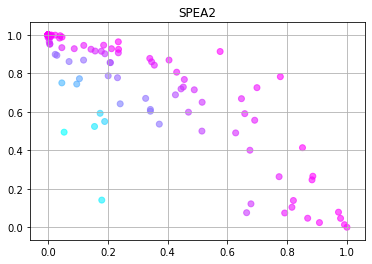

generation: 1


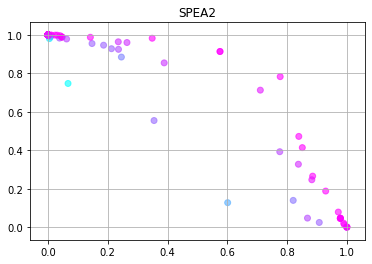

generation: 2


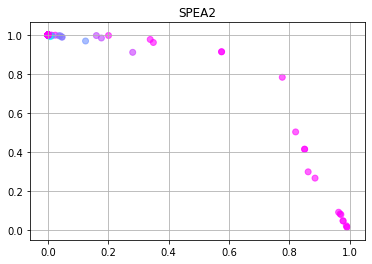

generation: 3


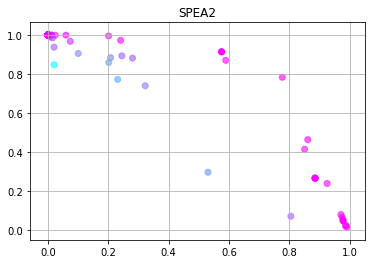

generation: 4


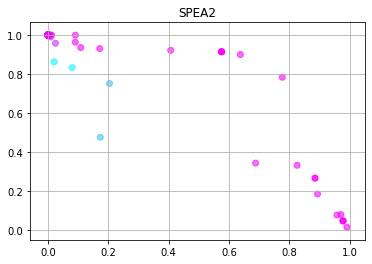

generation: 5


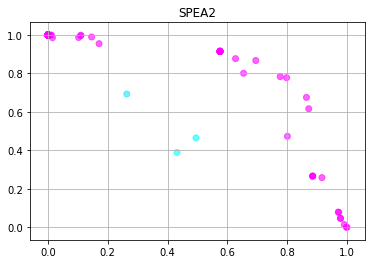

generation: 6


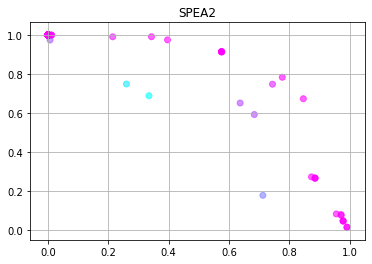

generation: 7


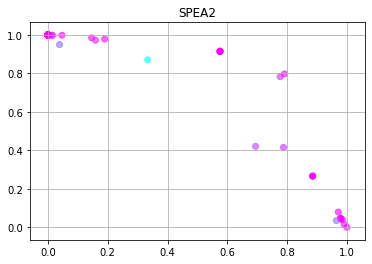

generation: 8


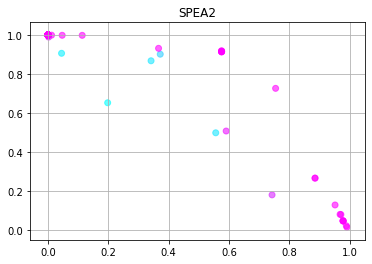

generation: 9


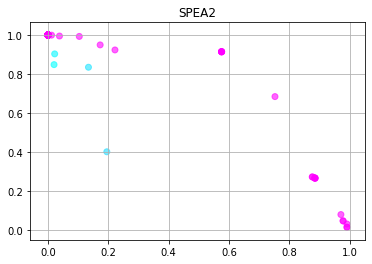

generation: 10


KeyboardInterrupt: 

In [43]:
#GP execution
dc,cs = MOGP.fit(Model)